<img src="Electronic_Brain.png" width="200" style="float:left">
<h1> Summer 2021 ML Course.</h1>
<h2> Exercise 7: Nonlinear Regression Models, Distribution Drift<br>Tools: Numpy, Pandas, Scikit-Learn</h2>

In [1]:
!python --version
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import gauss, randint
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from icecream import ic

Python 3.8.3


In [2]:
# Set a few defaults.
np.random.seed(42)
pd.set_option('display.precision', 3)
plt.rcParams['figure.figsize'] = [15, 5]

<img src="desktop-computer-icon.png" width="80" style="float:left">
<h1> &nbsp; Section A: Signal Generation.</h1>

In [3]:
"""
Generate AAPL's "bipolar" behavior, alternating between price levels of 10 and 30 USD with noise, for 20 days at a time.
Our target function today is a "long straddle".
Basically, the long straddle makes money on big price swings (up *OR* down),
and loses when prices are "calm" (within a relatively flat range).
"""
def generate_prices(sigma=5, regime_len=20, num_regimes=20):
    prices_df = pd.DataFrame()
    appl_prices = np.array([])
    for i in range(num_regimes):
        curr_prices = 20 + 10*(-1)**i + np.random.normal(0, sigma, regime_len)
        appl_prices = np.append(appl_prices, curr_prices)

    prices_df['AAPL'] = appl_prices

    # Generate backward & forward 10-day gains (*NOT* rolling means).
    prices_df['AAPL_back_10_day_gain'] = prices_df['AAPL'] - prices_df['AAPL'].shift(10)
    prices_df['AAPL_back_30_day_gain'] = prices_df['AAPL'] - prices_df['AAPL'].shift(30)

    # Create the "long straddle" (continuous) target function and its discrete version.
    prices_df['target'] = abs(prices_df['AAPL'] - prices_df['AAPL'].shift(-10)) - 20
    prices_df['discrete_target'] = prices_df['target'] > 0

    # Return a "clean" version of the prices dataframe, with no missing values.
    prices_df.dropna(inplace=True)
    return(prices_df)

In [4]:
Apple_df = generate_prices()
X = Apple_df[['AAPL_back_10_day_gain', 'AAPL_back_30_day_gain']]
y = Apple_df['target']
y_discrete = Apple_df['target'] > 0

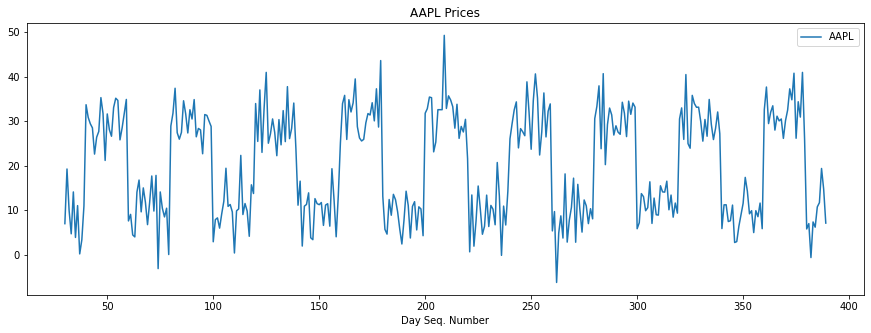

In [5]:
fig, ax = plt.subplots()
ax.plot(Apple_df['AAPL'], label='AAPL')
ax.set(xlabel='Day Seq. Number', title='AAPL Prices');
plt.legend();

<img src="desktop-computer-icon.png" width="80" style="float:left">
<h1> &nbsp; Section B: Feature & Target Extraction and Visualization</h1>

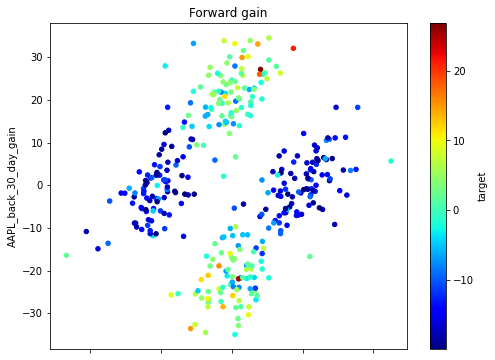

In [6]:
plt.rcParams['figure.figsize'] = [8,6]
Apple_df.plot.scatter(x="AAPL_back_10_day_gain", y="AAPL_back_30_day_gain", c="target", cmap='jet', title='Forward gain');

In [7]:
"""
Show the linear regression's output on the 2D plane defined by the two features.
"""
def show_regression(reg):
    # Define bounds of the domain.
    min1, max1 = Apple_df['AAPL_back_10_day_gain'].min()-5, Apple_df['AAPL_back_10_day_gain'].max()+5
    min2, max2 = Apple_df['AAPL_back_30_day_gain'].min()-5, Apple_df['AAPL_back_30_day_gain'].max()+5

    # Define the x and y grid.
    x1grid = np.linspace(min1, max1, 100)
    x2grid = np.linspace(min2, max2, 100)

    # Create the 2D grid.
    xx, yy = np.meshgrid(x1grid, x2grid)

    # Flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # Horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # Use the model to make predictions on the grid.
    y_hat = reg.predict(grid) # For all real-valued regression algs.

    # Reshape the predictions back into a grid.
    zz = y_hat.reshape(xx.shape)

    # Plot the grid of x, y and z values as a surface
    plt.rcParams['figure.figsize'] = [8,6]
    plt.contourf(xx, yy, zz, cmap='gray')

    # Add the actual training set as a scatter plot.
    c = plt.scatter(x=Apple_df["AAPL_back_10_day_gain"],
                    y=Apple_df["AAPL_back_30_day_gain"],
                    c=Apple_df["target"], cmap='jet');
    # Add a color bar.
    plt.colorbar(c);

In [8]:
"""
Perform 100-fold cross validation to estimate the regressor's accuracy.
Check the scikit-learn documentation to check how score() scores the regression algorithms.
"""
def eval_regression(reg_func, target_field, X_df):
    score_sum=0
    for _ in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X_df[["AAPL_back_10_day_gain", "AAPL_back_30_day_gain"]], X_df[target_field], test_size=0.1)
        reg_func.fit(X_train, y_train)
        score_sum += reg_func.score(X_test, y_test)
    return(score_sum/100)

<img src="desktop-computer-icon.png" width="80" style="float:left">
<h1> &nbsp; Section C: Regression Training and Visualization</h1>

ic| "Ordinary Least Squares score:": 'Ordinary Least Squares score:'
    score: -0.047766239088039536


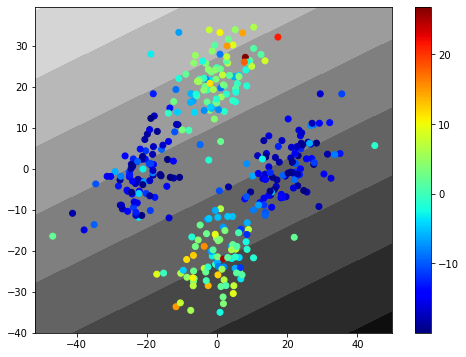

In [9]:
# Train a linear regressor on the continuous target.
ols_reg = LinearRegression()
ols_reg.fit(X, y)
# Show & evaluate the result.
show_regression(ols_reg)
score = eval_regression(ols_reg, 'target', Apple_df)
ic("Ordinary Least Squares score:", score);

<img src="Roni.png" width="50" style="float:left">
&nbsp; Please consult the scikit-learn documentation and look up the score() function. <br>
&nbsp; Then, explain to Ronny why his linear model failed to capitalize on Apple's predictable behavior...

&nbsp; &nbsp; Explanation:<br>
&nbsp; &nbsp; This is an example of the famous XOR problem, in which a linear classifier / regressor is unable to model an arrangement of data in a "XOR" pattern. The solution always involves adding a nonlinearity, as shown in the following sections.

KNN score for 33 neighbors: 0.6707287720837326


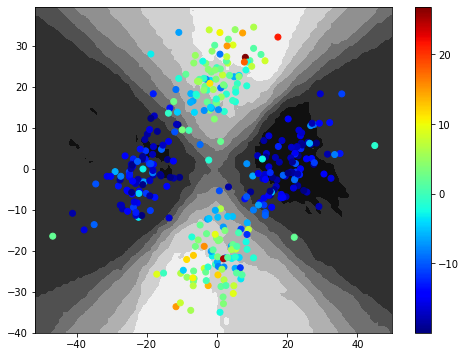

In [10]:
# Train K-nearest-neighbor regression.
num_neighbs=33
knn_reg = KNeighborsRegressor(n_neighbors=num_neighbs)
knn_reg.fit(X, y)
show_regression(knn_reg)
score = eval_regression(knn_reg, 'target', Apple_df)
print("KNN score for", num_neighbs, "neighbors:", score);

<img src="Motti.png" width="50" style="float:left">
&nbsp; Kindly help Motti (manually) optimize the number of neighbors to achieve a better fit!<br>
&nbsp; Setting the number of examples to n=1, we obtain a badly overfitted regression.<br>
&nbsp; Setting the number to n=100 results in underfitting, as not enough training samples are available.<br>
&nbsp; The optimal number is somewhere in the neighborhood of 30, give or take.

OLS regression with order 2 polynomial features: 0.5821676422271651


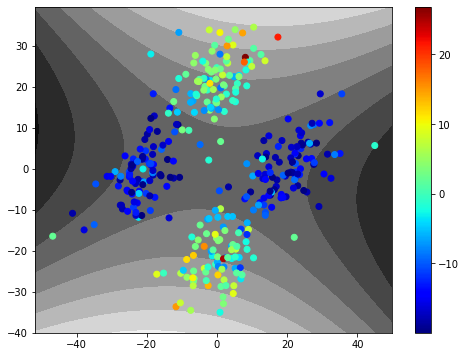

In [11]:
# Try using ordinary least squares with polynomial features.
poly_order = 2
regressor = LinearRegression()
ols_poly_model = make_pipeline(PolynomialFeatures(poly_order), regressor)
ols_poly_model.fit(X,y)
show_regression(ols_poly_model)
score = eval_regression(ols_poly_model, 'target', Apple_df)
print("OLS regression with order", poly_order, "polynomial features:", score)

<img src="Batya.png" width="60" style="float:left">
 &nbsp; Kindly help Batya (manually) optimize the polynomial dimension to achieve a good fit!<br>
 &nbsp; The optimal number is 2, additional degrees of freedom only hurt generalization.

In [12]:
"""
Show the linear regression's output on the 2D plane defined by the two features.
This version is suitable for classifiers (with probability outputs) as opposed to regressors.
The only difference is the use of the (scikit-learn standard) predict_proba() function.
"""
def show_classification_probs(cls):
    # Define bounds of the domain.
    min1, max1 = Apple_df['AAPL_back_10_day_gain'].min()-5, Apple_df['AAPL_back_10_day_gain'].max()+5
    min2, max2 = Apple_df['AAPL_back_30_day_gain'].min()-5, Apple_df['AAPL_back_30_day_gain'].max()+5

    # Define the x and y grid.
    x1grid = np.linspace(min1, max1, 100)
    x2grid = np.linspace(min2, max2, 100)

    # Create the 2D grid.
    xx, yy = np.meshgrid(x1grid, x2grid)

    # Flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # Horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # Use the model to make predictions on the grid.
    y_hat = cls.predict_proba(grid) # Use predict_proba() to access classification algs' probabilities.

    # Reshape the predictions back into a grid.
    zz = y_hat[:,0].reshape(xx.shape) # Use the first class' probability.

    # Plot the grid of x, y and z values as a surface
    plt.rcParams['figure.figsize'] = [8,6]
    plt.contourf(xx, yy, zz, cmap='gray')

    # Add the actual training set as a scatter plot.
    c = plt.scatter(x=Apple_df["AAPL_back_10_day_gain"],
                    y=Apple_df["AAPL_back_30_day_gain"],
                    c=Apple_df["target"], cmap='jet');
    # Add a color bar.
    plt.colorbar(c);

Logistic regression: 0.8197222222222229


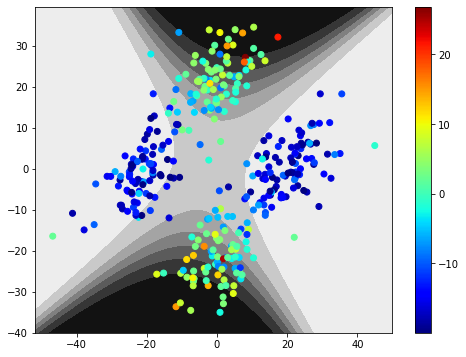

In [13]:
# Set up logistic regression for the problem.
poly_order = 2
regressor = LogisticRegression(random_state=0, max_iter=1500)
logistic_poly_model = make_pipeline(PolynomialFeatures(poly_order), regressor)
logistic_poly_model.fit(X,y_discrete)
show_classification_probs(logistic_poly_model)
score = eval_regression(logistic_poly_model, 'discrete_target', Apple_df)
print("Logistic regression:", score)

<img src="panicked_cat.png" width="120" style="float:left">
<h1> &nbsp; Section D: Re-evaluating Models on Drifting / Shifting Distributions</h1>
Please regenerate AAPL's price history, using values of regime_len in the [15, 60] range.<br>
Then, proceed to help our nervous cat check the model's performance when using the previously constructed<br>
OLS polynomial model on the new data (for each regime_len).<br>
NOTICE: logistic regression is measured as a classification algorithm, and therefore not directly comparable<br>
to the scores presented above for regressors. Please look up in the documentation!

In [14]:
# Regenerate AAPL's behavior, using different values of regime_len params.
# For each value, re-evaluate the *original* ols_poly_model on the new dataset, *without* retraining!
scores={}
for regime_len in range(15, 60):
    apple2_df = generate_prices(regime_len=regime_len)
    X = apple2_df[['AAPL_back_10_day_gain', 'AAPL_back_30_day_gain']]
    y = apple2_df['target']
    # Use the *existing* ols_poly_model (without retraining) to evaluate performance on the new dataset.
    scores[regime_len] = eval_regression(ols_poly_model, 'discrete_target', apple2_df)

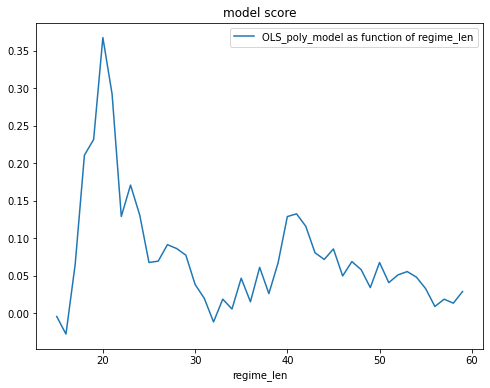

In [15]:
fig, ax = plt.subplots()
ax.plot(scores.keys(), scores.values(), label='OLS_poly_model as function of regime_len')
ax.set(xlabel='regime_len', title='model score');
plt.legend();

Please explain the resulting graph to our cat. When should the cat panic?

<img src="panicked_cat.png" width="120" style="float:left">
<h1> &nbsp; Explanation</h1><br>
The cat should indeed panic when the data's distribution has shifted!<br>
The features used (10 & 30 day delays) were exactly fitted to the data, which had a regime change every 20 days.<br>
When the data shifted to k-day-long regimes, k in [15..60], the features' value quickly deteriorated.<br>
Notice that the features are more useful for and around k=40, as this is a harmonic of 20.